# 6. Modelling
The purpose of this notebook is to create various models and try and determine which one works best for the project task. As well as trying various models, I will also experiment with different features and perform feature engineering to try and get the best predictors. As I go through this process I will try and explore the data further and continue with EDA while in the process since it is an iterative process
In this chapter I am going to build machine learning models to help us classify whether pumps in Tanzania are function, not function or functioning and needs repair. This is a ternary problem meaning we have three target classes

In [12]:
#importing necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import accuracy_score, auc, f1_score,  classification_report
import warnings
warnings.filterwarnings("ignore")
from Metricsfunction import plot_matrix, metrics
from xgboost import XGBClassifier
import joblib


In [13]:
#reading our data
modelling_data = pd.read_csv("modelling_data.csv")
#printing the first five rows
modelling_data.head()

,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,lga,population,extraction_type_group,...,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,installer,permit,public_meeting
0,functional,50.0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,Ludewa,109,gravity,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,Roman,False,True
1,functional,0.0,1399,34.698766,-2.147466,Lake Victoria,Mara,Serengeti,280,gravity,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,GRUMETI,True,True
2,functional,25.0,686,37.460664,-3.821329,Pangani,Manyara,Simanjiro,250,gravity,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,World vision,True,True
3,non functional,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,submersible,...,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,UNICEF,True,True
4,functional,0.0,0,31.130847,-1.825359,Lake Victoria,Kagera,Karagwe,0,gravity,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,Artisan,True,True


Summary statistics our our numerical columns

In [14]:
#summary statistics
modelling_data.describe()

,amount_tsh,gps_height,longitude,latitude,population
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000
mean,12.748566,668.297239,34.077427,-5.706033e+00,179.909983
std,20.976109,693.116350,6.567432,2.946019e+00,471.482176
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,25.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,215.000000
max,50.000000,2770.000000,40.345193,-2.000000e-08,30500.000000


I will  now select our target and the features from our data set so we can start building our models. Our target column is "status_group" and the other columns will be our features. We will also create a label encoder mapper to transform our target classes into 0,1 and 2

In [15]:
#label encoding
modelling_data["status_group"].replace({"functional": 0, "non functional": 1, "functional needs repair": 2}, inplace= True)
#selecting target
y = modelling_data["status_group"]
#selecting features
X = modelling_data.select_dtypes(["float", "int"])
X = X.drop("status_group", axis= 1)



We will need to to normalize all features into a consistent scale of 0 to 1 since classification models only choose from  0 or 1 especially for numeric features. After that we will split the data into train and test splits so we can train evaluate and test our model. Since this is a ternary classification we will split our data into three sets; train, validate and test. Train will take 70% of the data while validate and train will take 15 % each.

In [16]:
#splitting data into train and combine(val and test)
X_train, X_combined, y_train, y_combined = train_test_split(X, y, train_size= 0.7, random_state= 1)
#splitting combined into validate and test
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, train_size= 0.5, random_state= 1)

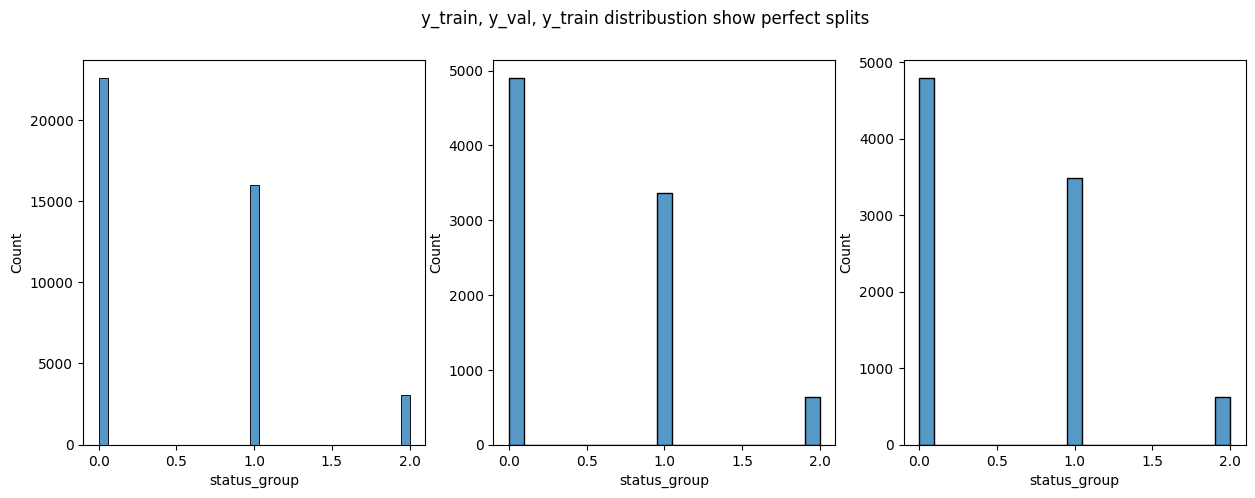

In [17]:
fig, ax = plt.subplots(ncols= 3, figsize= (15, 5))
sns.histplot(x =y_train, ax = ax[0])
sns.histplot(y_val, ax = ax[1])
sns.histplot(y_test, ax = ax[2])
plt.suptitle("y_train, y_val, y_train distribustion show perfect splits")
plt.show();


Normalizing our data and OneHotEncoding our target column using a pipeline. We use pipelines to ensure flow in our work and to avoid data leakage in our process. We will also introduce smote here but we will use it later in our notebook

In [18]:
#SMOTE 
smote = SMOTE(sampling_strategy='auto', random_state=42)
#normalizing using StandardScaler()
scaler_pipeline =  Pipeline(steps= [("scaler", StandardScaler())])
#onehotencoding our categorical column
ohe_pipeline = Pipeline(steps=[("ohe", OneHotEncoder(drop= "first"))])
#creating a transformer
transformer = ColumnTransformer(transformers= [
                                ("scaler", scaler_pipeline, [0, 1, 2, 3, 4])],remainder= "passthrough")

## 6.1 Vanilla LogisticRegression Model.
This a pure logistic regression classification model with no tuning.

In [19]:
#logistic regression pipeline
logistic_pipeline = Pipeline(steps= [
                        ("transformer", transformer),
                        ("logreg", LogisticRegression(max_iter= 200, random_state= 42))
                                ])
#fit our data
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4])])),
                ('logreg', LogisticRegression(max_iter=200, random_state=42))])

In [20]:
#X_train prediction
train_pred = logistic_pipeline.predict(X_train)
#getting the train metrics
metrics(y_train, train_pred)


              precision    recall  f1-score   support

           0       0.59      0.81      0.68     22568
           1       0.53      0.34      0.42     15965
           2       0.00      0.00      0.00      3047

    accuracy                           0.57     41580
   macro avg       0.37      0.39      0.37     41580
weighted avg       0.52      0.57      0.53     41580



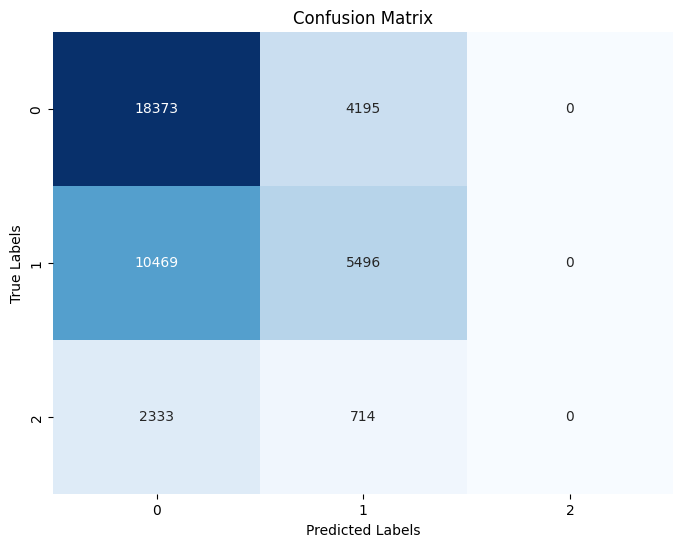

In [21]:
plot_matrix(y_train, train_pred, logistic_pipeline)

In [22]:
#validating our model
val_pred = logistic_pipeline.predict(X_val)
metrics(y_val, val_pred)


              precision    recall  f1-score   support

           0       0.59      0.82      0.69      4900
           1       0.52      0.33      0.40      3369
           2       0.00      0.00      0.00       641

    accuracy                           0.58      8910
   macro avg       0.37      0.38      0.36      8910
weighted avg       0.52      0.58      0.53      8910



              precision    recall  f1-score   support

           0       0.58      0.82      0.68      4791
           1       0.54      0.34      0.42      3490
           2       0.00      0.00      0.00       629

    accuracy                           0.57      8910
   macro avg       0.37      0.39      0.37      8910
weighted avg       0.52      0.57      0.53      8910



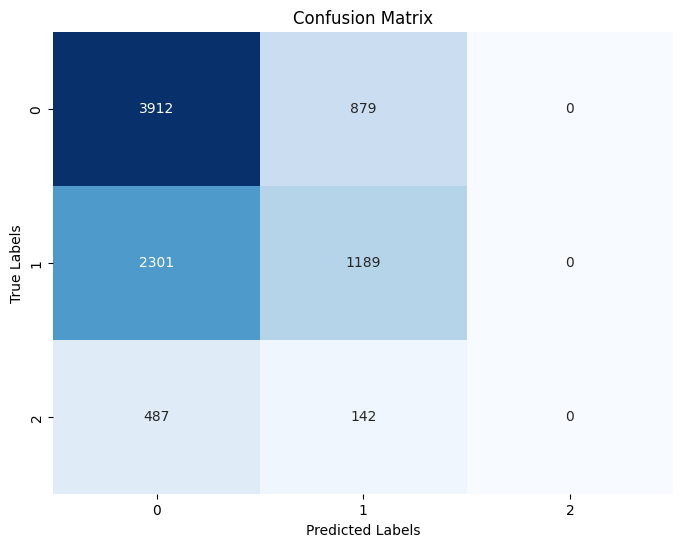

In [23]:
#testing our model
test_pred = logistic_pipeline.predict(X_test)
metrics(y_test, test_pred)
plot_matrix(y_test, test_pred, logistic_pipeline)


Our vanilla model has an accuracy of 57%. That is not a bad score for a baseline model meaning that our model is capturing the data well considering that we have not accounted for class imbalance. It is doing well on unseen data as we can see that the test metrics are not far off from the train metrics
#
I will go ahead and plot a Logistic regressor that accounts for our class imbalance

## 6.2 LogisticRegressionCV
This is a tuned logistic regression model that searches for the best regularization parameter using cross validation. Remember that our target class is also imbalanced and that can make the model favour the most appearing  class. I will sort the class imbalance using weights that are inversely proportional to our class frequencies. I will just just pass the argument "balanced" to class weight paramater.

In [24]:
#building LogisticRegressionCV with balanced classes
logistic_pipelineCV = Pipeline(steps= [
                                    ("transformer", transformer),
                                    ("logregCV", LogisticRegressionCV(max_iter= 100, cv= 5, class_weight = "balanced",random_state=1))])
#fit the data
logistic_pipelineCV.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4])])),
                ('logregCV',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      random_state=1))])

Fitting our model and getting the score of our model

              precision    recall  f1-score   support

           0       0.70      0.42      0.52     22568
           1       0.47      0.74      0.57     15965
           2       0.21      0.19      0.20      3047

    accuracy                           0.52     41580
   macro avg       0.46      0.45      0.43     41580
weighted avg       0.57      0.52      0.52     41580



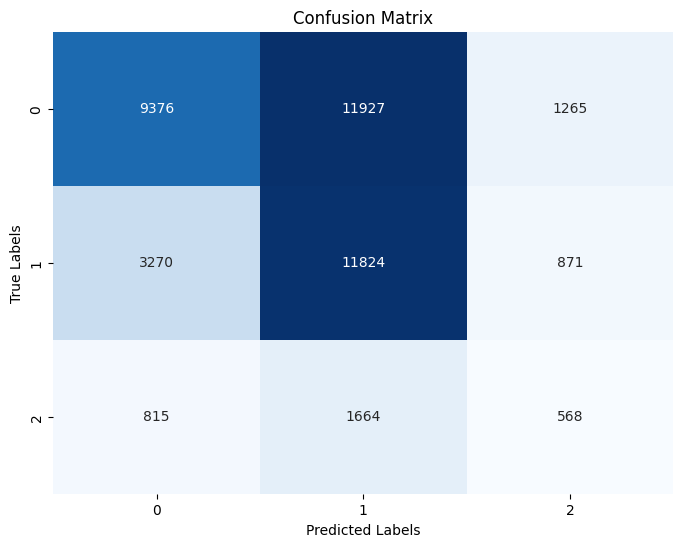

In [25]:
#train score
train_pred = logistic_pipelineCV.predict(X_train)
metrics(y_train, train_pred)
plot_matrix(y_train, train_pred, logistic_pipeline)

Validating our model and obtaining the validation score

In [26]:
#fit X_val
val_pred = logistic_pipelineCV.predict(X_val)
#val score
metrics(y_val, val_pred)

              precision    recall  f1-score   support

           0       0.70      0.42      0.52      4900
           1       0.45      0.73      0.56      3369
           2       0.24      0.21      0.22       641

    accuracy                           0.52      8910
   macro avg       0.46      0.45      0.43      8910
weighted avg       0.57      0.52      0.51      8910



Finally we will test our model and also obtain the test score

              precision    recall  f1-score   support

           0       0.67      0.40      0.51      4791
           1       0.47      0.73      0.57      3490
           2       0.18      0.16      0.17       629

    accuracy                           0.52      8910
   macro avg       0.44      0.43      0.42      8910
weighted avg       0.56      0.52      0.51      8910



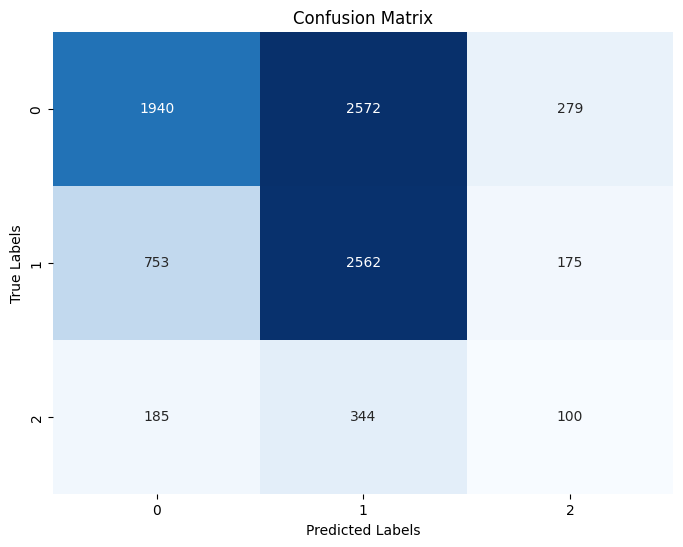

In [27]:
#fit the data
test_pred = logistic_pipelineCV.predict(X_test)
#test score
metrics(y_test, test_pred)
plot_matrix(y_test, test_pred, logistic_pipeline)

Our cross validation logistic regression model has underperformed compared to the previous vanilla model. The model also predicts a lot of false positives on the train data as well on the test data.This is not a good model as such we will use trees in our next model
## 6.3 DecisionTreeClassifier

This classifier performs a recursive partition of the sample space efficiently as possible into sets with similar data points until you get close to a homogenous set and can reasonably predict the value for the new data points.
I am going to build a basic tree to see how it performs on how data before tuning it again to see if it improves or not. I will also add extra categorical features to the model since I have been using only numerical columns in my initial model. I will use pipelines here. I will drop the columns that i dont need first.

In [28]:
#dropping columns we don't need
X_new = modelling_data.drop(["status_group", "basin", "region", "lga", "management", "source_class", "installer"], axis = 1)


Performing train, validate and test splits on our data

In [29]:
#performing train, validate, test split for our new added features
X_train, X_combined, y_train, y_combined = train_test_split(X_new, y, train_size= 0.7, random_state=1, stratify= y)
#val and test split
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, train_size= 0.5, random_state=1, stratify= y_combined)

Creating a column transformer pipeline to help us concatenate our preprocessing steps

In [30]:
#using pipeline to encode and fit our model
#scaling or numerical columns and encoding categorical columns
transformer2 = ColumnTransformer(transformers= [
                                ("scaler", scaler_pipeline, [0, 1, 2, 3, 4]),
                                ("ohe", ohe_pipeline, [5, 6, 7, 8, 9, 10, 11, 12, 13]),], remainder= "passthrough")

In this model we will use SMOTE technique to account for class imbalanace

In [31]:
tree_pipeline = Pipeline(steps = [
                        ("transformer2", transformer2),
                        ("smote", smote),
                        ("tree_clf", DecisionTreeClassifier())
])
#fitting our train values
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13])])),
                ('smote', SMOTE(random_state=42)),
                ('tree_clf', DecisionTreeClassifier())])

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     22581
           1       1.00      1.00      1.00     15977
           2       0.95      0.99      0.97      3022

    accuracy                           0.99     41580
   macro avg       0.98      0.99      0.99     41580
weighted avg       0.99      0.99      0.99     41580



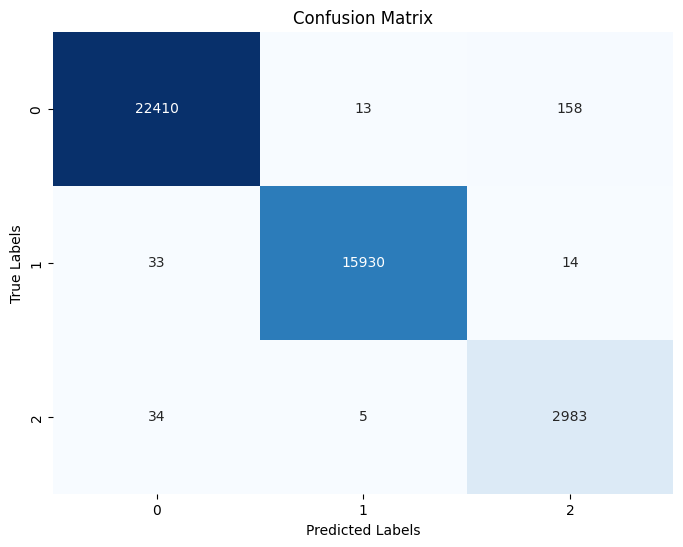

In [32]:
#train score and accuracy
train_pred = tree_pipeline.predict(X_train)
metrics(y_train, train_pred)
plot_matrix(y_train, train_pred, tree_pipeline)

In [33]:
#fit our validation set and see the score
val_pred = tree_pipeline.predict(X_val)
#validation score
metrics(y_val, val_pred)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      4839
           1       0.76      0.77      0.76      3424
           2       0.33      0.47      0.39       647

    accuracy                           0.74      8910
   macro avg       0.63      0.66      0.64      8910
weighted avg       0.75      0.74      0.74      8910



              precision    recall  f1-score   support

           0       0.80      0.75      0.77      4839
           1       0.76      0.75      0.76      3423
           2       0.31      0.46      0.37       648

    accuracy                           0.73      8910
   macro avg       0.62      0.66      0.63      8910
weighted avg       0.75      0.73      0.74      8910



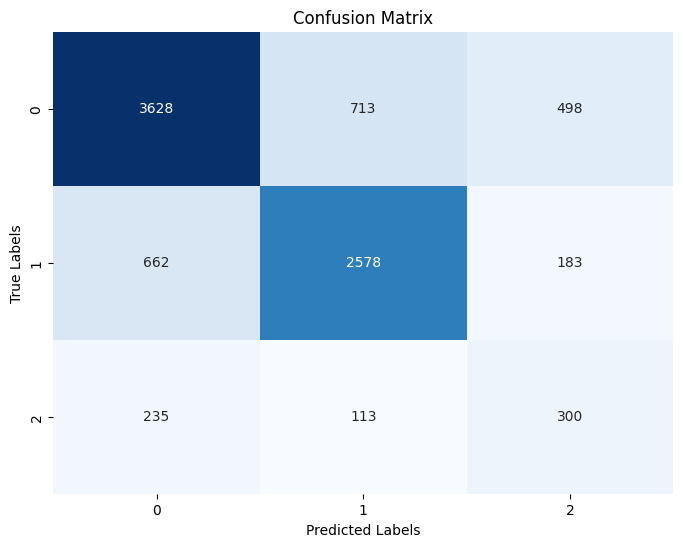

In [34]:
#fit our test set
test_pred = tree_pipeline.predict(X_test)
#test score
metrics(y_test, test_pred)
plot_matrix(y_test, test_pred, tree_pipeline)

Wow! Our decision tree classifier seems to be working better with a score of 74% on the test set than our previous cross-validation regressor which had a score of 51%. The tree performs badly on the unseen data as we can see that it has a score of almost 100% on the train data but has a score of 75% on the validate and test data. In short the model gives a good prediction on the training data but when given unseen or new data it fails badly.
We will tune our tree and see if we can improve its performance on unseen data by finding the best prunning values

### Hyperparameter tuned DecisionTree 
I am going to tune my model hyperparameyters such as "max_depth", "min_sample_leaf" among others. I am going to see if this will improve my model performance. It is often referred to as to as the hyperparameter space for the optimum values. I'll use, Combinatoric Grid Searching, ehich is probably the most popular because it performs an exhaustive search of all possible combinations. Grid Search works by training a model on the data for each unique combination of parameters and then returning the parameters of the model that performed best. To protect us from randomness, I will use K-Fold cross-validation during this step. 

In [35]:
#creating dictionary grid
param_grid = {  "tree_clf__max_depth": [None, 1, 3],
                "tree_clf__min_samples_split": [2, 3],
                "tree_clf__min_samples_leaf": [1, 2, 3],
                "tree_clf__criterion": ["gini", "entropy"]}
#instantiate GridSearchCV
grid = GridSearchCV(tree_pipeline , param_grid,
                    cv=3, return_train_score= True)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('tree_clf', DecisionTreeClassifier())]),
             param_grid={'tree_clf__criterion': ['gini', 'entropy'],
                         'tree_clf__max_depth': [None, 1, 3],
                         'tree_clf__min_samples_leaf': [1, 2, 3],
                         'tree_clf__min_samples_split': [2, 3]},
             return_train_score=True)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     22581
           1       0.97      0.92      0.94     15977
           2       0.88      0.80      0.84      3022

    accuracy                           0.94     41580
   macro avg       0.93      0.90      0.91     41580
weighted avg       0.94      0.94      0.94     41580

{'tree_clf__criterion': 'gini', 'tree_clf__max_depth': None, 'tree_clf__min_samples_leaf': 2, 'tree_clf__min_samples_split': 3}


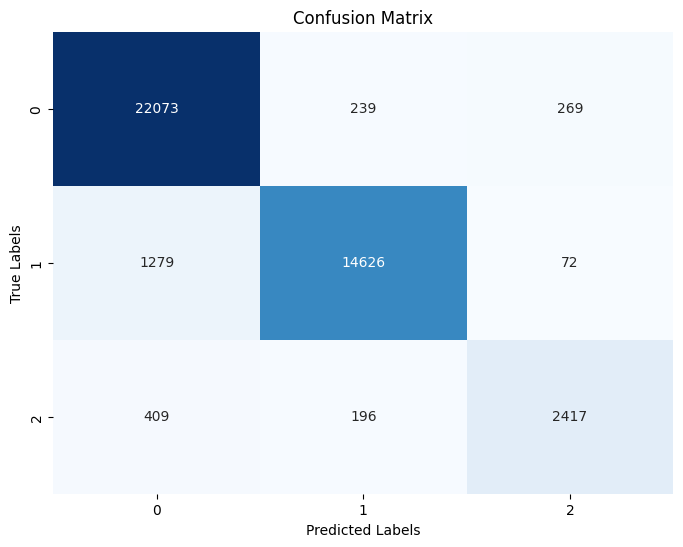

In [36]:
#train predict
train_pred = grid.predict(X_train)
#train score
metrics(y_train, train_pred)
#best params
print(grid.best_params_)
plot_matrix(y_train, train_pred, grid)

In [37]:
#fit the validation set
val_pred = grid.predict(X_val)
#score
metrics(y_val, val_pred)
print(grid.best_params_)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4839
           1       0.77      0.74      0.75      3424
           2       0.35      0.43      0.39       647

    accuracy                           0.74      8910
   macro avg       0.64      0.65      0.64      8910
weighted avg       0.75      0.74      0.75      8910

{'tree_clf__criterion': 'gini', 'tree_clf__max_depth': None, 'tree_clf__min_samples_leaf': 2, 'tree_clf__min_samples_split': 3}


              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4839
           1       0.77      0.73      0.75      3423
           2       0.32      0.41      0.36       648

    accuracy                           0.74      8910
   macro avg       0.63      0.64      0.63      8910
weighted avg       0.75      0.74      0.74      8910

{'tree_clf__criterion': 'gini', 'tree_clf__max_depth': None, 'tree_clf__min_samples_leaf': 2, 'tree_clf__min_samples_split': 3}


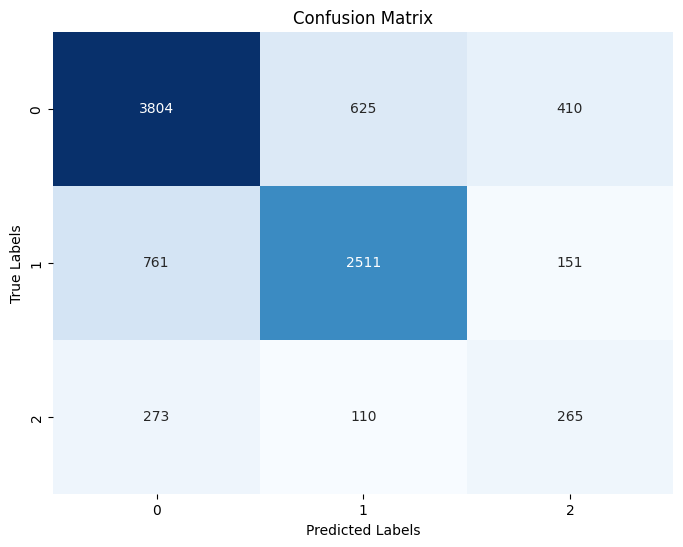

In [38]:
#fit the test set
test_pred = grid.predict(X_test)
#test score
metrics(y_test, test_pred)
print(grid.best_params_)
plot_matrix(y_test, test_pred, grid)

After iterating over a sample space of hyperparameter tuning, our model has improved on its performance. Its score has increased 76% and biase tradeoff between the train score and the test score has also reduced significantly. This indicates that our model tuning is working and improves our model.
I will go ahead and use ensemble methods to boost our accuracy further. This an iterative process also that entails tuning of models to achieve the optimal score

## 6.4 RandomForest
This is an upgrade of DecisionTree classifier which uses greedy algorithm to maximize information gain at every step.

In [39]:
#instantiating RandomForest 
forest_pipeline = Pipeline(steps= [
                        ("transformer2", transformer2),
                        ("smote", smote),
                        ("rf", RandomForestClassifier())
])
#fit train set
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13])])),
                ('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     22581
           1       1.00      1.00      1.00     15977
           2       0.94      0.99      0.97      3022

    accuracy                           0.99     41580
   macro avg       0.98      0.99      0.99     41580
weighted avg       0.99      0.99      0.99     41580



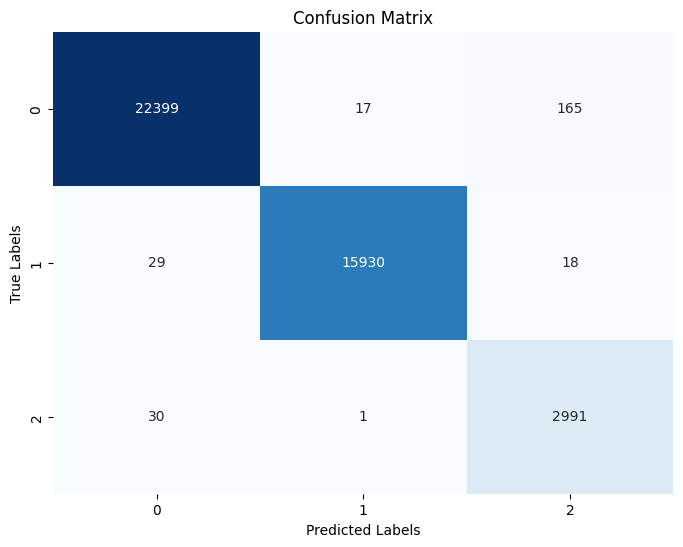

In [40]:
# train predict
train_pred = forest_pipeline.predict(X_train)
#score
metrics(y_train, train_pred)
plot_matrix(y_train, train_pred, forest_pipeline)


In [41]:
#predicting y_val
val_pred = forest_pipeline.predict(X_val)
#score
metrics(y_val, val_pred)


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4839
           1       0.81      0.79      0.80      3424
           2       0.40      0.50      0.44       647

    accuracy                           0.78      8910
   macro avg       0.68      0.70      0.69      8910
weighted avg       0.79      0.78      0.79      8910



              precision    recall  f1-score   support

           0       0.82      0.80      0.81      4839
           1       0.80      0.78      0.79      3423
           2       0.37      0.48      0.42       648

    accuracy                           0.77      8910
   macro avg       0.66      0.69      0.67      8910
weighted avg       0.78      0.77      0.77      8910



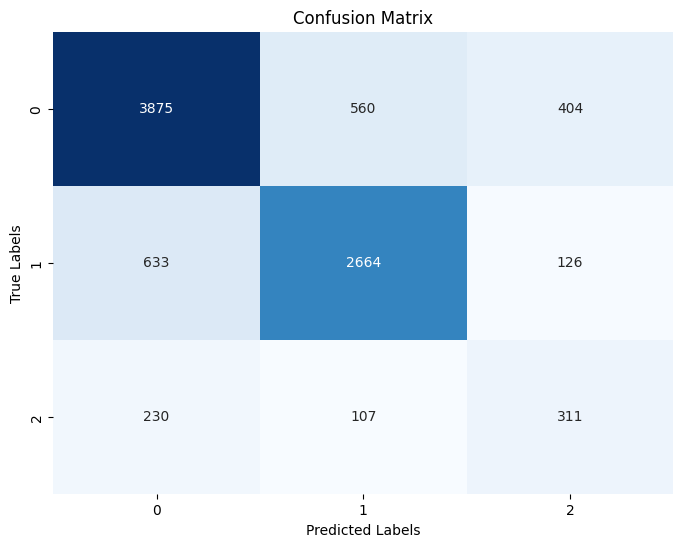

In [42]:
#predicting y_test
test_pred = forest_pipeline.predict(X_test)
#score
metrics(y_test, test_pred)
plot_matrix(y_test, test_pred, forest_pipeline)

Our forest seems to work well on unseen data but slightly performs poorly on the validate and test data. It has increased accuracy compared to the model but it seems to overfit. Lets tune it to see the performance
## Tuned RandomForest
The first vanilla ensemble method has a better score than the model before this. It is almosting achieving 80% score on the test data. It is performing poorly on unseen data as we can see the difference between the train score(99%) and test score(80) is huge. We will pass the grid search pipeline and use cross validation to see if our model will improve like in the previous models. Before that i will plot a feature importance graph to show the features our model has used most. I will write a helper function to help us with this

In [43]:
param_grid = {  "rf__max_depth": [None,1,],
                "rf__min_samples_split": [2, 4, 5],
                "rf__min_samples_leaf": [2, 3,],
                "rf__criterion": ["gini", "entropy"]}
#using the grid hyperparameter space
forest_grid = GridSearchCV(forest_pipeline, param_grid,
                    cv= 3, return_train_score= True)
#fit train set
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 1],
                         'rf__min_samples_leaf': [2, 3],
                         'rf__min_samples_split': [2, 4, 5]},
             return_train_score=True)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     22581
           1       0.93      0.88      0.90     15977
           2       0.60      0.86      0.71      3022

    accuracy                           0.89     41580
   macro avg       0.82      0.88      0.84     41580
weighted avg       0.90      0.89      0.90     41580

{'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2}


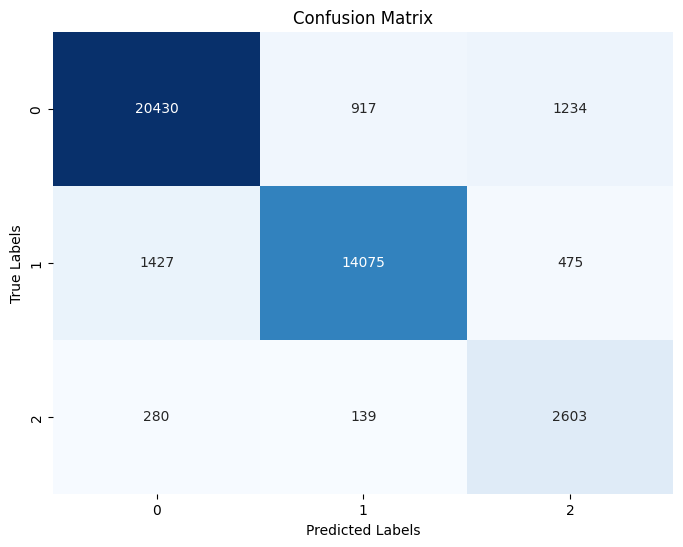

In [44]:
#train score
train_pred= forest_grid.predict(X_train)
metrics(y_train, train_pred)
print(forest_grid.best_params_)
plot_matrix(y_train, train_pred, forest_grid)

In [45]:
#val predict
val_pred = forest_grid.predict(X_val)
#accuracy
print(f"Validation accuracy is {accuracy_score(y_val, val_pred)}")
print(forest_grid.best_params_)

Validation accuracy is 0.7693602693602694
{'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2}


tets accuracy is 0.7664421997755331
{'rf__criterion': 'entropy', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2}


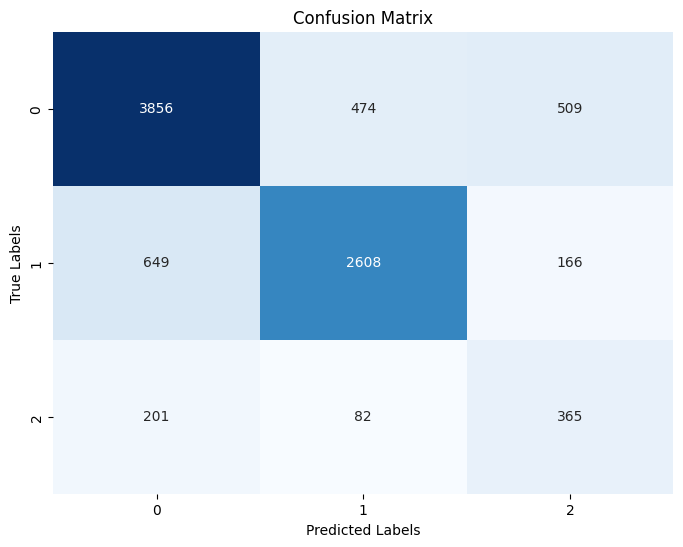

In [46]:
#test predict
test_pred = forest_grid.predict(X_test)
#accuracy
print(f"tets accuracy is {accuracy_score(y_test, test_pred)}")
print(forest_grid.best_params_)
plot_matrix(y_test, test_pred, forest_grid)

Tuning our random forest algorithm has made it perform well and achieves a test score of 76%. The model seems almost to do well on unseen data as we can see the validate and test metrics are not so far from the training metrics unlike in the previous models. This a good sign that our model is doing better than the previous models. It also has a high number of true positives values meaning the number of observations where the model predicted the pump is functioning and it was really functioning is high. I will further build another complex model to see if I can acheive a better score
## 6.5 GradientBoosting
This algorithm uses errors from its previous weak learners to improve on those errors. It brief it uses its errors from previous learners to learn, correct and try find the best curve

In [47]:
boosting_pipeline = Pipeline(steps= [
                            ("transformer2", transformer2),
                            ("smote", smote),
                            ("booster", GradientBoostingClassifier())
])

In [48]:
boosting_param = {  
                    "booster__n_estimators": [4, 7, 8],
                    "booster__learning_rate": [1, 0.1],
                    "booster__max_depth": [3, 4, 6],
                    "booster__min_samples_split": [2, 3],
                    "booster__min_samples_leaf": [6, 7, 8]}

In [49]:
boosting_grid = GridSearchCV(boosting_pipeline, param_grid= boosting_param,
                            cv= 3, n_jobs= -1, return_train_score= True)
#fit train_set
boosting_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('booster',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'booster__learning_rate': [1, 0.1],
                         'booster__max_depth': [3, 4, 6],
                         'booster__min_samples_leaf': [6, 7, 8],
                         'booster__min_samples_split': [2, 3],
                         'booster__n_estimators': [4, 7, 8]},
             return_train_score=True)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78     22581
           1       0.81      0.73      0.77     15977
           2       0.31      0.67      0.42      3022

    accuracy                           0.73     41580
   macro avg       0.64      0.72      0.66     41580
weighted avg       0.78      0.73      0.75     41580



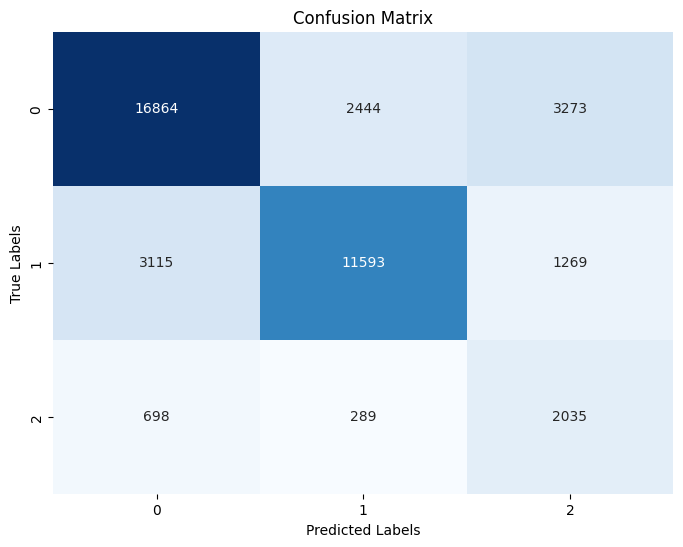

In [50]:
#train predict
train_pred = boosting_grid.predict(X_train)

metrics(y_train, train_pred)
plot_matrix(y_train, train_pred,boosting_grid)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      4839
           1       0.78      0.71      0.75      3424
           2       0.26      0.58      0.36       647

    accuracy                           0.70      8910
   macro avg       0.61      0.67      0.62      8910
weighted avg       0.75      0.70      0.72      8910



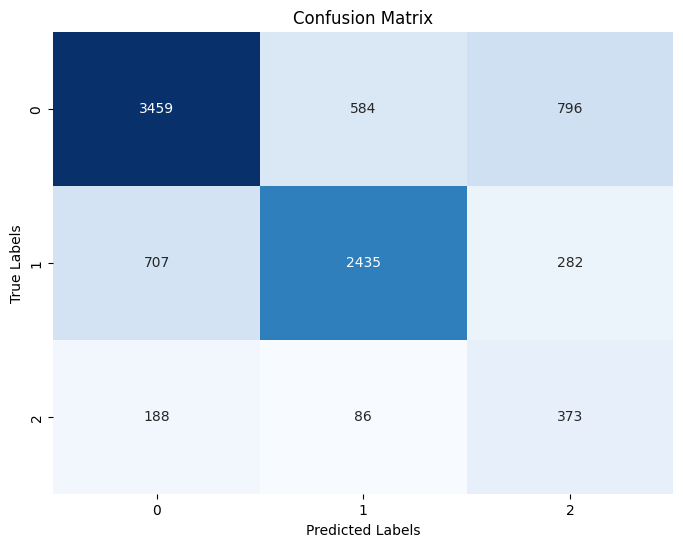

In [51]:
val_pred = boosting_grid.predict(X_val)
metrics(y_val, val_pred)
plot_matrix(y_val, val_pred, boosting_grid)

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      4839
           1       0.79      0.69      0.74      3423
           2       0.26      0.58      0.36       648

    accuracy                           0.70      8910
   macro avg       0.61      0.66      0.62      8910
weighted avg       0.75      0.70      0.72      8910



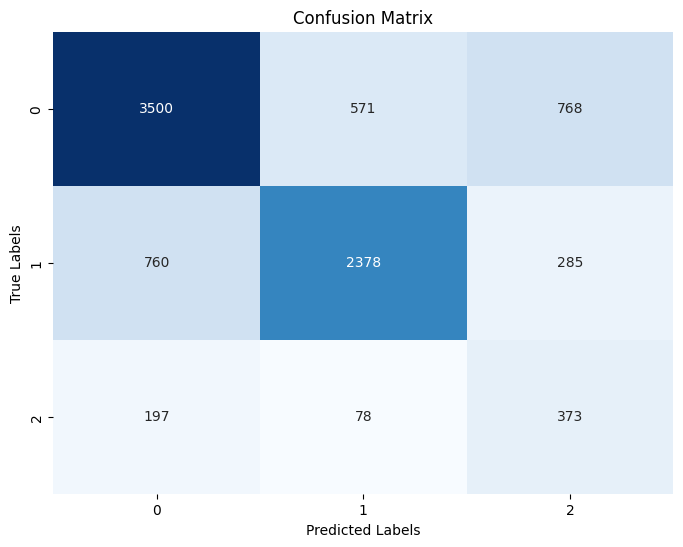

In [52]:
test_pred = boosting_grid.predict(X_test)
print(classification_report(y_test, test_pred))
plot_matrix(y_test, test_pred, boosting_grid)

Our boosting model is performing well better than all previous models. Its training score is almost equal to the validate and test score indicating that it does not overfit and works well on unseen data. It has a test score of 70% almost similar to the tuned random forest classifier  but has dropped a bit. I will one final model to see if i can further improve the accuracy.

## 6.7 XGboost
Known as extreme gradient boosting. Known for handling missing values well, lucky for us we dealt with that.

In [53]:
#xgboost pipeline
xg_pipeline = Pipeline(steps= [
                            ("transformer2", transformer2),
                            ("smote", smote),
                            ("xgboost",XGBClassifier())
                                
])
#defining grid params
xg_grid  = boosting_param = {  
                    "xgboost__n_estimators": [4, 7, 8],
                    "xgboost__learning_rate": [1, 0.1],
                    "xgboost__max_depth": [3, 4, 6]}

In [54]:
#building our xgboost
xg_boost = GridSearchCV(xg_pipeline, param_grid= xg_grid,
                        cv= 4, n_jobs= -1, return_train_score= True)
#fit training data
xg_boost.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      bo...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__learning_rate': [1, 0.1],
                         'xgboost__max_depth': [3, 4, 6],
                         'xgboost__n_estimators': [4, 7, 8]},
             return_train_score=True)

              precision    recall  f1-score   support

           0       0.78      0.75      0.77     22581
           1       0.79      0.70      0.74     15977
           2       0.28      0.55      0.37      3022

    accuracy                           0.72     41580
   macro avg       0.62      0.67      0.63     41580
weighted avg       0.75      0.72      0.73     41580



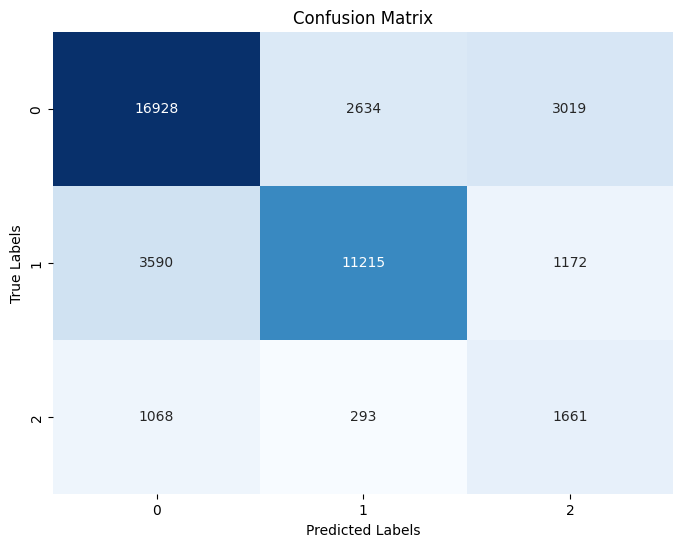

In [55]:
#predic X_train
train_pred = xg_boost.predict(X_train)
#scores and matrix
metrics(y_train, train_pred)
plot_matrix(y_train, train_pred, xg_boost)

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      4839
           1       0.79      0.71      0.74      3424
           2       0.25      0.49      0.33       647

    accuracy                           0.71      8910
   macro avg       0.61      0.64      0.61      8910
weighted avg       0.74      0.71      0.72      8910



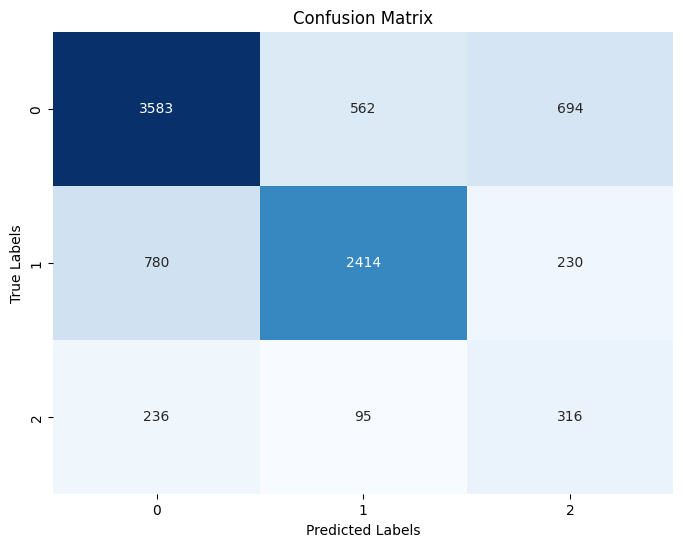

In [56]:
#val score
val_pred = xg_boost.predict(X_val)
#score and matrix
metrics(y_val, val_pred)
plot_matrix(y_val, val_pred, xg_boost)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      4839
           1       0.78      0.69      0.73      3423
           2       0.26      0.50      0.34       648

    accuracy                           0.70      8910
   macro avg       0.60      0.64      0.61      8910
weighted avg       0.74      0.70      0.71      8910



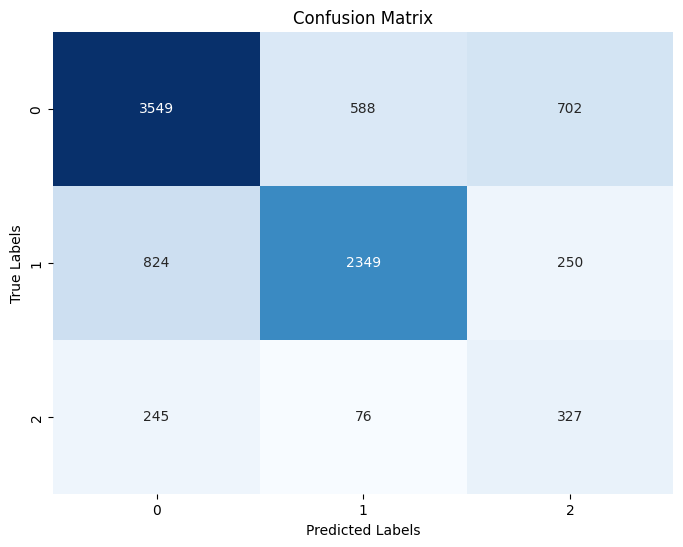

In [57]:
#test_score
test_pred = xg_boost.predict(X_test)
#score and matrix
metrics(y_test, test_pred)
plot_matrix(y_test, test_pred, xg_boost)

The XGBoost model is performing not badly too. It has a train score of 72% which is almost similar to what the gradient boosting model had achieved. Its validate and test metric is almost equal to the training model meaning this model performs well on unseen data. The model also predicts a high number of true positives.
### Final Model
I evaluated my models using the accuracy, precision and recall but accuracy was the main metric I used in my process. Why accuracy? This is becasuse it gives an overall picture of how often the model correctly predicts the status of the water pumps across all classes. Accuracy represents the ratio of correctly predicted water pump statuses (functional, non-functional, needs repair) to the total predictions made. It provides an overall percentage of correct predictions, regardless of the individual class distribution, offering a comprehensive assessment of the model's correctness across all categories.
#### Best model
After an iterative and tedious practice of training and testing machine learning models, I have comeup with best performing model from the rest of the others. I have picked a model that does well on unseen data to avoid making false positive predictions when deployed to solve real world problems.These are the accuracy score for all my model;

In [58]:
#Accuracy score for the ML models
print(f'The Accuracy score for LogisticRegression() is: {round(accuracy_score(y_test, logistic_pipeline.predict(X_test)), 2)}')
print(f'The Accuracy score for LogisticRegressionCV is: {round(accuracy_score(y_test, logistic_pipelineCV.predict(X_test)), 2)}')
print(f'The Accuracy score for DecisionTree() is: {round(accuracy_score(y_test, tree_pipeline.predict(X_test)), 2)}')
print(f'The Accuracy score for Tuned DecisionTree() is: {round(accuracy_score(y_test, grid.predict(X_test)), 2)}')
print(f'The Accuracy score for RandomForest() is: {round(accuracy_score(y_test, forest_pipeline.predict(X_test)), 2)}')
print(f'The Accuracy score for Tuned RandomForest() is: {round(accuracy_score(y_test, forest_grid.predict(X_test)), 2)}')
print(f'The Accuracy score for GradientBoosting() is: {round(accuracy_score(y_test, boosting_grid.predict(X_test)), 2)}')
print(f'The Accuracy score for XGBoost() is: {round(accuracy_score(y_test, xg_boost.predict(X_test)), 2)}')

The Accuracy score for LogisticRegression() is: 0.57
The Accuracy score for LogisticRegressionCV is: 0.53
The Accuracy score for DecisionTree() is: 0.73
The Accuracy score for Tuned DecisionTree() is: 0.74
The Accuracy score for RandomForest() is: 0.77
The Accuracy score for Tuned RandomForest() is: 0.77
The Accuracy score for GradientBoosting() is: 0.7
The Accuracy score for XGBoost() is: 0.7


From the metrics above we can see that the `RandomForest` and the `tuned RAndomForest` have the high accuracy score. These are the two best machine learning models in terms of accuracy score. I will forego these two for the `GradientBooster` or the XGBoost since the boosting algorithms do well on unseen data unlike the RandomForest which does well on training data but does poorly on the validate and test data.

In general XGBoost was the best performing model with a accuracy score of 70%. This model was able to do well on all the train, validate and test sets of data meaning it would perform better if given unseen data. It also had the highest number of True positives(where it predicted a model wa functional and in it got it right). We are going to save our model so we can deploy it for  or use it whenever we need it. I am going to use joblib library for this.

In [59]:
#saving our model
joblib.dump(xg_boost, 'final_model.pkl')

['final_model.pkl']

This is the end of our model training, validation and testing. Machine learning models are the best to use because of many reasons but i will mention few;


1. Complex Patterns: Machine learning excels at identifying complex patterns and relationships within data that might not be easily discernible through simpler methods. It can uncover nonlinear relationships and interactions among variables.


2. Scalability: Machine learning models can handle large volumes of data efficiently. They can scale well with increasing data size, allowing for analysis of massive datasets that might overwhelm traditional analytical approaches.

3. Predictive Power: Machine learning models, especially when properly trained and validated, can make accurate predictions or classifications on new, unseen data. This predictive capability is valuable for forecasting future trends or outcomes.

4. Adaptability and Flexibility: Machine learning models can adapt to changing data patterns and are flexible enough to accommodate various data types and structures without manual adjustments.
### Challenges
There were a few challenges between the process and are as follows'
1. Low computational power to build the models and this affected testing and evaluating process as the process of building took so long

2. A lot of dirty work to clean in the dataset. The dataset had outliers, missing values and duplicates and this consumed almost all of my time on analysis.

3. There was an issue with class imbalance in the target group and had to employ techniques like weights and synthetic to curb the problem
### Conclusion

In conclusion, predicting the functionality of water pumps in Tanzania presents a pivotal opportunity to ensure sustainable access to clean water for communities. Leveraging predictive models allows proactive maintenance interventions, optimizing resource allocation, and minimizing downtime. By harnessing historical data encompassing pump functionality, geographical attributes, and maintenance records, these models enable stakeholders to anticipate potential failures, prioritize repairs, and sustain reliable water access across Tanzania. This predictive capability, coupled with community engagement and qualitative insights, paves the way for a holistic approach towards efficient water infrastructure management, fostering a more resilient and inclusive water supply system for Tanzanian communities.
### Recommendations
1. Investment in Maintenance: Prioritize proactive maintenance based on model predictions. Allocate resources to address potential pump failures or those requiring repair, reducing downtime and ensuring consistent water supply.

2. Regular Data Updates: Ensure continuous data collection and updates to maintain model accuracy. 

3. Community Involvement: Foster community engagement to gather qualitative insights, user feedback, and local perspectives.

4. Investment in Technology: Explore the integration of IoT sensors or remote monitoring technologies to gather real-time data on pump functionality. This technology can enhance predictive capabilities and facilitate proactive maintenance strategies.


### Next step
1. Deploy our model into use to see how it will perform in the business world.

2. Improve on computational power in order to analyze data with ease
